# Dataloader

## read data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os

In [2]:
def get_path(path4):
    target_files = []

    for root, dirs, files in os.walk(path4):
        targets = [os.path.join(root, f) for f in files]
        target_files.extend(targets)
    return target_files

In [3]:
train_path="/Research/Data/rgb/train"
val_path="/Research/Data/rgb/test"

train_files = get_path(train_path)
val_files=get_path(val_path)

In [4]:
import numpy as np
import random
import torch
import random
from torchvision import transforms as transforms
from PIL import Image, ImageFilter

In [5]:
class DataTransform():

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                transforms.RandomRotation(degrees=(-90,90)),
                #transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': Compose([
                transforms.ToTensor(),
                #transforms.CenterCrop(224),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }

    def __call__(self, phase,img):
        
        img = self.data_transform[phase](img)

        return img

In [6]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self,img):
        for t in self.transforms:
            img = t(img)

        return img

## Dataset

In [7]:
#フォルダ名からラベルを作成 (key:number ,value:indivisual number)
def makelabels(path):
    #フォルダ名を取得
    label_list=os.listdir(path)
    label_files=[]

    for i in range(len(label_list)):
        if not("MATLAB" in label_list[i]):
            label_files.append(label_list[i])

    #dicに格納
    lable_dic={}
    for j in range(len(label_files)):
        lable_dic[str(j)]=label_files[j]

    return lable_dic

classindex=makelabels(train_path)

In [8]:
import torch.utils.data as data

class CowDataset(data.Dataset):

    def __init__(self,target_files,phase,transform,classindex):
        self.phase=phase
        self.transform=transform
        self.target_files=target_files
        self.classindex=classindex

    def __len__(self):
        return len(self.target_files)

    def __getitem__(self,index):
        img,one_hot = self.pull_item(index)
        return img,one_hot

    def pull_item(self,index):
        self.path=self.target_files[index]

        #onehot label
        if self.phase=="train":
            label=self.path[25:28]
        else:
            label=self.path[24:27]

        key = [k for k, v in self.classindex.items() if v == label]
        one_hot=int(key[0])

        #cow img
        img = Image.open(self.path)  # [高さ][幅][色BGR]
        img=self.transform(self.phase,img)

        return img,one_hot


In [9]:
# 動作確認
train_dataset=CowDataset(train_files, phase="train", transform=DataTransform(),classindex=classindex)
val_dataset=CowDataset(val_files, phase="val", transform=DataTransform(),classindex=classindex)

In [10]:
batch_size=64

train_dataloader=data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# 辞書型変数
dataloaders_dict = {"train": train_dataloader, "val":val_dataloader}

## Dataloader

In [ ]:
# データの取り出し例
item = train_dataset.__getitem__(0)
print(item[0].size())  # sequence size
print(item[1])  #onehot vector

In [13]:
# 動作の確認
batch_iterator = iter(dataloaders_dict["train"])  # イタレータに変換
item = next(batch_iterator)  # 1番目の要素を取り出す
print(item[0].size())  # img
print(item[1])

torch.Size([256, 3, 224, 224])
tensor([160,  60, 294,  28, 233, 296, 110,  36,  22, 196, 272, 194,  98, 182,
         50, 245, 188,  59,   2, 227, 203, 304, 203, 181, 212, 188, 286, 217,
         87, 112, 258,  30, 308, 137, 228, 285, 132, 166, 264, 106, 112, 302,
        280, 100,  26, 239,  71,  92, 118, 236, 123, 225, 245, 124,  41,  75,
         32, 194,  66, 237, 173,  42,  96, 286, 206, 179,   8, 130,  34, 291,
        318, 225, 223, 109, 235,  84, 316,  82, 132, 183,  18, 248, 146, 153,
        178, 281, 185,  70, 257, 190,   4,  66, 247,  99, 320,  62, 222,  85,
        144, 166, 107,  86,  28,  28, 106, 236, 228,  60,  33, 301, 282, 285,
        293, 118,  27, 245, 317,  80, 200, 106,  75, 114,  64,  30, 196, 258,
        278,  52, 318, 173, 250, 106, 229,   4, 257, 263,  51, 111, 279, 281,
        257, 182, 180, 140, 261, 201,  73, 250, 101, 246,  13, 247, 239, 303,
        254, 125,  43, 241, 209, 270, 134, 218, 197, 247, 163, 202,  88, 217,
         69, 204, 185,  10, 209, 

# Other Network

In [11]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import numpy as np

In [12]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, transforms
import torchvision
import numpy as np
import random

## resnet

In [13]:
use_pretrained = True
net=models.resnet50(pretrained=use_pretrained)

In [15]:
net.fc = nn.Linear(in_features=2048, out_features=321)

## Ark face

In [14]:
from util import  arkFace

In [15]:
class ArkFace(nn.Module):
    def __init__(self):
        super(ArkFace,self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet.fc = nn.Linear(in_features=2048, out_features=512)
        self.metric = arkFace.ArcMarginProduct(in_features=512, out_features=321,easy_margin=True)

    def forward(self,inputs,labels):
        feature=self.resnet(inputs)
        out=self.metric(feature,labels)

        return out

In [16]:
net=ArkFace()

# Training

In [17]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [18]:
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### network setting

In [19]:
optimizer = optim.SGD(net.parameters(),lr=0.1,weight_decay=5e-4)#,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 損失関数の設定
criterion = nn.CrossEntropyLoss()

### trainning model

In [20]:
from tensorboardX import SummaryWriter
writer = SummaryWriter("./tbX/")

In [21]:
from sklearn.metrics import confusion_matrix

def train_model(net,dataloaders_dict,criterion,optimizar,num_epochs):

    #check GPU
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device:",device)

    #netをデバイスへ移動
    net.to(device)
    #net2.to(device)

    conf_mem=[]
    #ネットがある程度固定であれば,高速化
    torch.backends.cudnn.benchmark = True

    #epoch roop
    for epoch in range(num_epochs):
        #start time
        t_epoch_start=time.time()

        print("----------")
        print("Epoch{}/{}".format(epoch+1,num_epochs))
        print("----------")

        #train val roop
        for phase in ["train","val"]:
            if phase == "train":
                net.train()
                optimizar.zero_grad()

            else:
                net.eval()

            # 損失和
            epoch_loss = 0.0
            # 正解数
            epoch_corrects = 0
            #Top5
            correct_k = 0
            correct10_k = 0

            predlist=torch.zeros(0,dtype=torch.long, device='cpu')
            lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

            for images,labels in dataloaders_dict[phase]:
                #Note! batchsize 1 occur error,
                if images.size()[0] == 1:
                    continue

                #initialize optimizer
                optimizer.zero_grad()

                #to device
                images=images.to(device)
                labels = labels.to(device)

                #forward propagation
                with torch.set_grad_enabled(phase=="train"):
                    outputs=net(images,labels)
                    loss=criterion(outputs,labels)
                    _,preds=torch.max(outputs,1)

                    #back propagation
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        predlist=torch.cat([predlist,preds.view(-1).cpu()])
                        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])


                    # lossの合計を更新
                    epoch_loss += loss.item() * images.size(0)
                    del loss
                    epoch_corrects += torch.sum(preds == labels.data)
                    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                    epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)


                    #Top5の正解数を更新
                    _, indices = outputs.topk(5, dim = 1,  largest=True, sorted=True)
                    prediction=indices.t()
                    top5_correct = prediction.eq(labels.view(1, -1).expand_as(prediction))
                    correct_k += top5_correct[:5].reshape(-1).float().sum(0, keepdim=True)
                    epoch_top5_acc = correct_k.double() / len(dataloaders_dict[phase].dataset)
                    epoch_top5_acc = epoch_top5_acc.to('cpu').detach().numpy().copy()


                    _, indices10 = outputs.topk(10, dim = 1,  largest=True, sorted=True)
                    prediction10=indices10.t()
                    top10_correct = prediction10.eq(labels.view(1, -1).expand_as(prediction10))
                    correct10_k += top10_correct[:10].reshape(-1).float().sum(0, keepdim=True)
                    epoch_top10_acc = correct10_k.double() / len(dataloaders_dict[phase].dataset)
                    epoch_top10_acc = epoch_top10_acc.to('cpu').detach().numpy().copy()




            print('{} Loss: {:.4f} Top1-Acc: {:.4f} Top5-Acc: {:.4f} Top10-Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_top5_acc[0], epoch_top10_acc[0]))

            if phase == "train":
                scheduler.step()
                writer.add_scalar("TRAIN_Loss",epoch_loss,epoch)
                writer.add_scalar("TRAIN_acc",epoch_acc,epoch)
                
            else:
                #Confusion matrix
                conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                conf_mem.append(conf_mat)

                writer.add_scalar("VAL_Loss",epoch_loss,epoch)
                writer.add_scalar("VAL_acc",epoch_acc,epoch)
                
                #print('lr = {:4f}:'.format(scheduler.get_last_lr()[0]))


        t_epoch_finish=time.time()
        print("Timer: {:.4f} sec.".format(t_epoch_finish - t_epoch_start))
        t_epoch_start=time.time()
    return conf_mem

In [22]:
# 学習・検証を実行
num_epochs = 60
conf_mem=train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Device: cuda:0
----------
Epoch1/60
----------
train Loss: 0.0305 Top1-Acc: 0.0065 Top5-Acc: 0.0085 Top10-Acc: 0.0094
val Loss: 0.2689 Top1-Acc: 0.0000 Top5-Acc: 0.0003 Top10-Acc: 0.0003
Timer: 496.5897 sec.
----------
Epoch2/60
----------
train Loss: 0.0236 Top1-Acc: 0.0665 Top5-Acc: 0.0946 Top10-Acc: 0.1120
val Loss: 0.2417 Top1-Acc: 0.0061 Top5-Acc: 0.0064 Top10-Acc: 0.0154
Timer: 451.9547 sec.
----------
Epoch3/60
----------
train Loss: 0.0079 Top1-Acc: 0.3253 Top5-Acc: 0.5189 Top10-Acc: 0.6040
val Loss: 0.2722 Top1-Acc: 0.0000 Top5-Acc: 0.0029 Top10-Acc: 0.0099
Timer: 454.0381 sec.
----------
Epoch4/60
----------
train Loss: 0.0038 Top1-Acc: 0.7638 Top5-Acc: 0.9017 Top10-Acc: 0.9356
val Loss: 0.2980 Top1-Acc: 0.0000 Top5-Acc: 0.0000 Top10-Acc: 0.0000
Timer: 459.0288 sec.
----------
Epoch5/60
----------
train Loss: 0.0010 Top1-Acc: 0.8780 Top5-Acc: 0.9603 Top10-Acc: 0.9779
val Loss: 0.1098 Top1-Acc: 0.1531 Top5-Acc: 0.3938 Top10-Acc: 0.4951
Timer: 459.9731 sec.
----------
Epoch6/60

In [22]:
from torchvision import models
torch.save(net.to('cpu').state_dict(), './weights/resnet151_Ark.pth')

## TEST

In [24]:
model_path = './weights/resnet101.pth'
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [49]:
import torch.utils.data as data

class testDataset(data.Dataset):

    def __init__(self,target_files,phase,transform,classindex):
        self.phase=phase
        self.transform=transform
        self.target_files=target_files
        self.classindex=classindex

    def __len__(self):
        return len(self.target_files)

    def __getitem__(self,index):
        img,one_hot,name = self.pull_item(index)
        return img,one_hot,name

    def pull_item(self,index):
        self.path=self.target_files[index]
        name=self.path
        #onehot label
        if self.phase=="train":
            label=self.path[34:51]
        else:
            label=self.path[32:49]

        key = [k for k, v in self.classindex.items() if v == label]
        one_hot=int(key[0])

        #cow image
        #img=mat2py(self.path)
        img=img2py(self.path)
        img=self.transform(self.phase,img)

        return img, one_hot, name

In [50]:
test_dataset=testDataset(val_files, phase="val", transform=DataTransform(),classindex=classindex)

In [51]:
batch_size=32
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [76]:
def detect_incorrect_data(net,test_dataloader):
    net.eval()
    device="cuda"
    corrects=0
    incorect=[]
    net.to(device)
    for images,labels,files in test_dataloader:
        #to device
        images=images.to(device)
        labels = labels.to(device)
        outputs=net(images)
        _,preds=torch.max(outputs,1)
        a= (preds == labels.data)
        corrects += torch.sum(a)

        for i in range(len(files)):
            if a[i]==False:
                incorect.append(files[i])

    corrects/len(test_dataloader.dataset)
    incorect.sort()
    return incorect

In [77]:
incorect=detect_incorrect_data(net,test_dataloader)

In [78]:
incorect

['/Project/Data/DATA5/3D_VAL_DATA\\LA900116002063402\\LA900116002063402_70.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002063402\\LA900116002063402_82.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002087039\\LA900116002087039_73.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002087039\\LA900116002087039_79.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002087039\\LA900116002087039_8.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002087039\\LA900116002087039_82.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002087039\\LA900116002087039_9.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002089631\\LA900116002089631_78.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002089631\\LA900116002089631_79.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002089631\\LA900116002089631_8.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002089631\\LA900116002089631_80.csv',
 '/Project/Data/DATA5/3D_VAL_DATA\\LA900116002089631\\LA900116002089631_89.csv',
 '/Project/Data/DATA5/3D_VAL_DA

# Result

confusion matrix

In [37]:
import seaborn as sns

In [38]:
conf=conf_mem[-1]
conf_sum=np.sum(conf,1)
conf=conf/conf_sum
conf=np.round(conf,decimals=3)

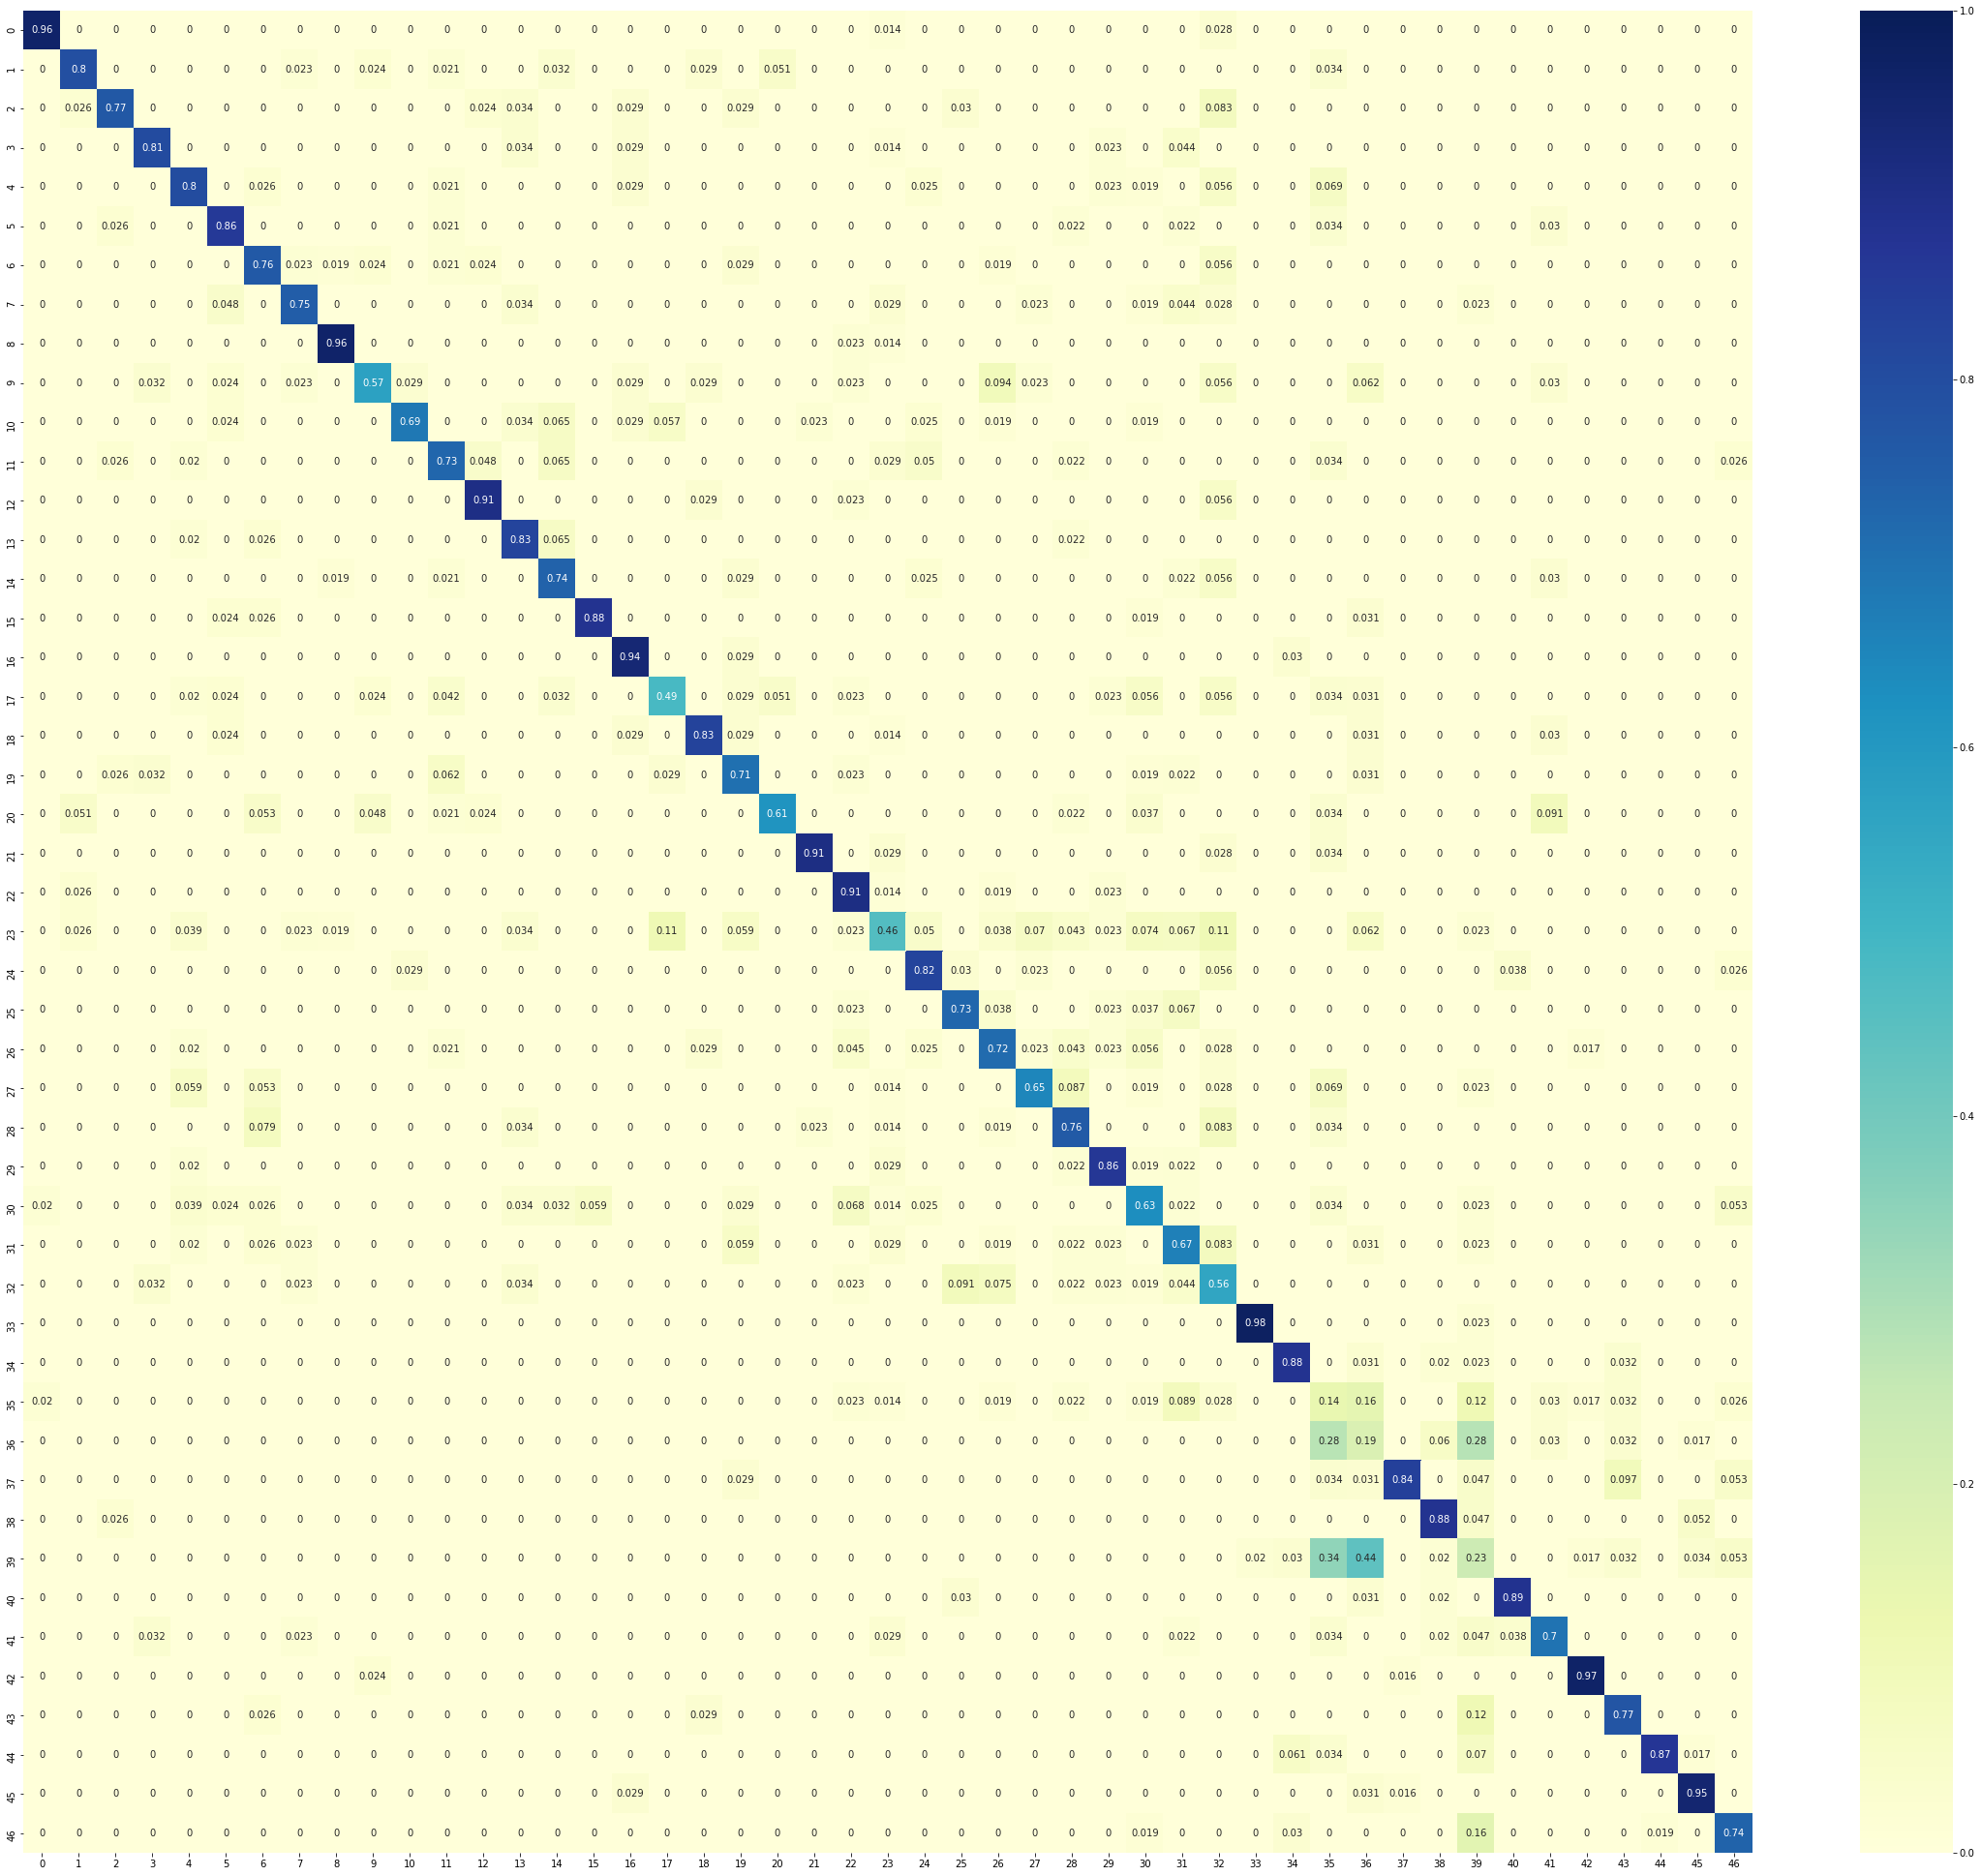

In [39]:
f, ax = plt.subplots(figsize=(40, 35))
sns.heatmap(conf, vmax=1, annot=True,cmap="YlGnBu");

PCA,TSNE

In [40]:
feature=net.metric.weight.to('cpu').detach().numpy().copy()

for i in range(47):
    x=feature[i,:]
    x_l2_norm = np.linalg.norm(x,ord=2)
    feature[i,:]=feature[i,:]/x_l2_norm

df = pd.DataFrame(feature)

In [41]:
from sklearn.decomposition import PCA
model_pca = PCA(n_components=2)
vecs_list = model_pca.fit_transform(df)

In [46]:
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, perplexity=3)
vecs_list = model_tsne.fit_transform(df)

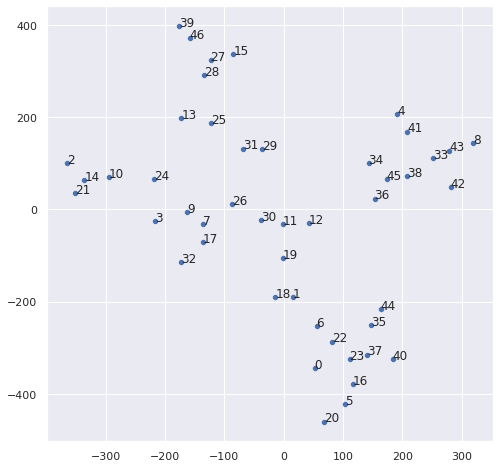

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

X = vecs_list[:,0]
Y = vecs_list[:,1]

sns.set(font="Hiragino Maru Gothic Pro")
plt.figure(figsize=(8, 8))

sns.scatterplot(x=X,y=Y)

for i,(x_name,y_name) in enumerate(zip(X,Y)):
    plt.annotate(df.index[i],(x_name,y_name))

## cos smilally

In [48]:
cosmat=np.dot(feature,feature.T)
df2 = pd.DataFrame(cosmat)

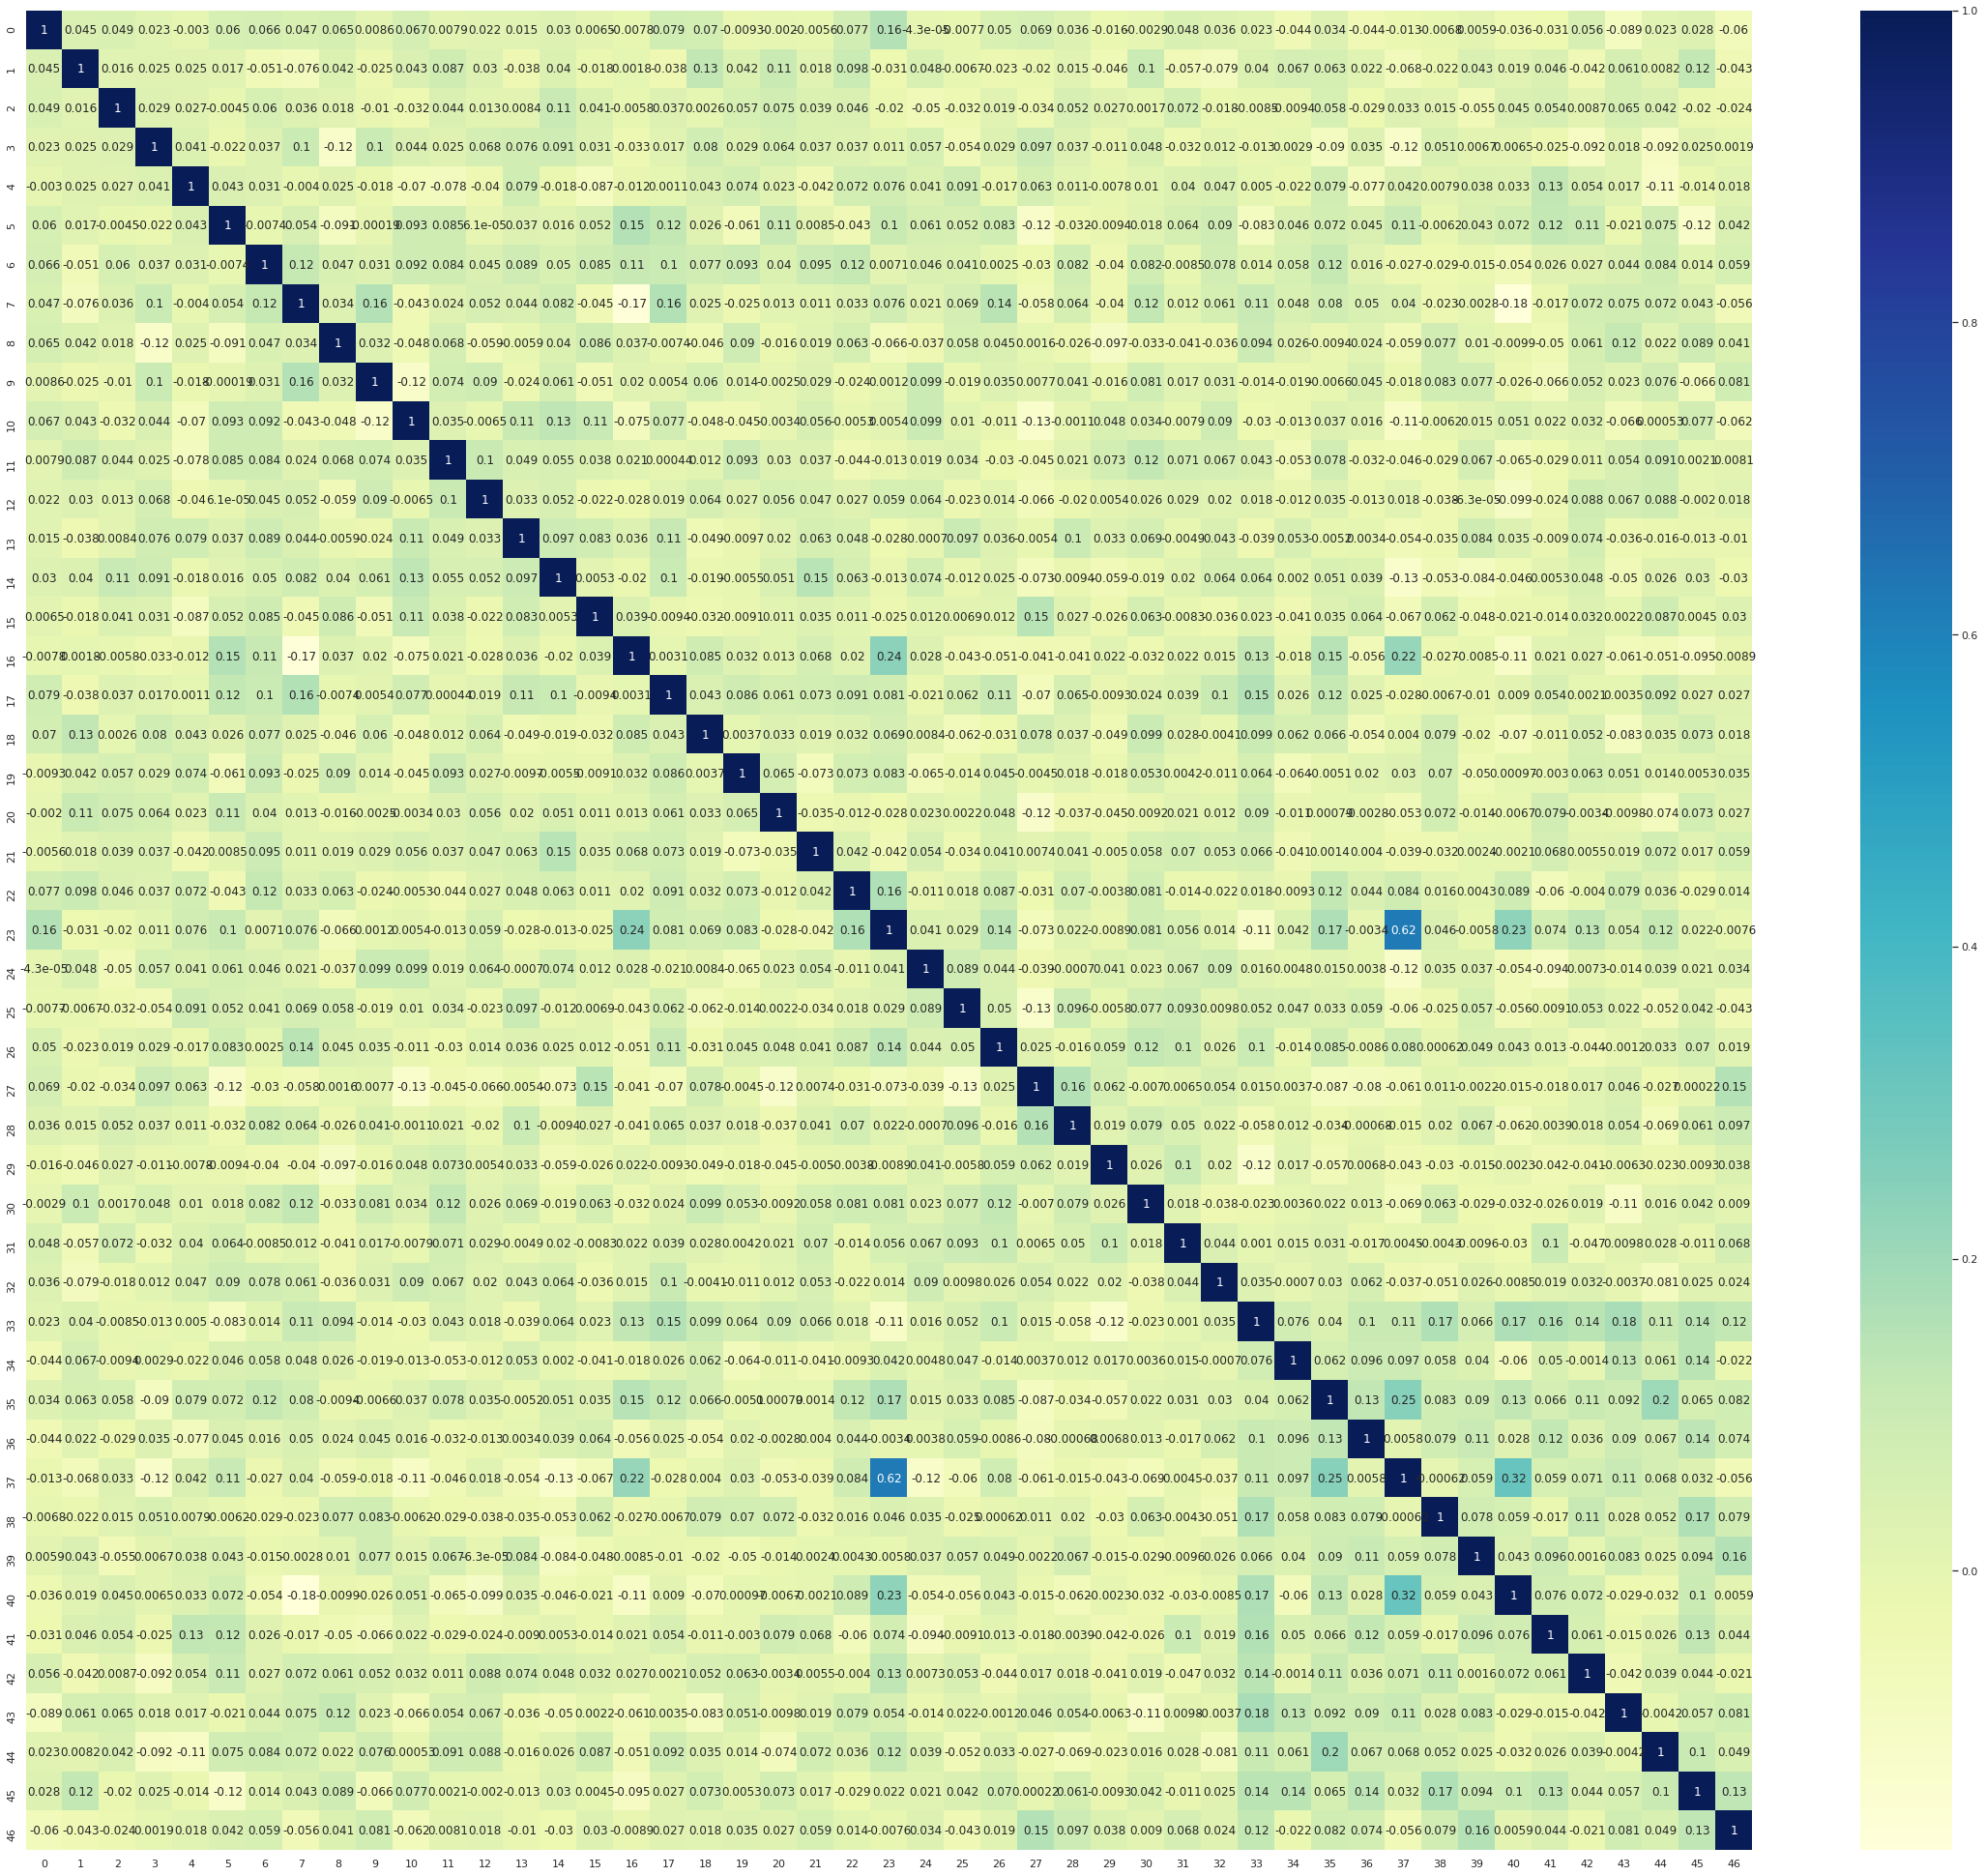

In [51]:
f, ax = plt.subplots(figsize=(40, 35))
sns.heatmap(cosmat, vmax=1, annot=True,cmap="YlGnBu");

In [49]:
model_tsne = TSNE(n_components=2, perplexity=3)
vecs_list = model_tsne.fit_transform(df2)

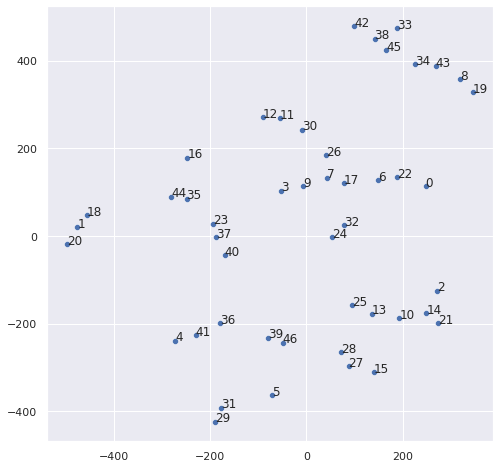

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

X = vecs_list[:,0]
Y = vecs_list[:,1]

sns.set(font="Hiragino Maru Gothic Pro")
plt.figure(figsize=(8, 8))

sns.scatterplot(x=X,y=Y)

for i,(x_name,y_name) in enumerate(zip(X,Y)):
    plt.annotate(df.index[i],(x_name,y_name))